In [30]:
%matplotlib inline

from skimage import io, util, segmentation
import numpy as np
import os
import sys
import math
import timeit
import matplotlib.pyplot as plt

In [31]:
def get_k_centers(k, height, width):
    grid_y, grid_x = np.mgrid[:height, :width]
    slices = util.regular_grid((height, width), k)
    step_y, step_x = [s.step if s.step is not None else 1 for s in slices]
    centers_y = grid_y[slices]
    centers_x = grid_x[slices]
    
    centers = np.concatenate([centers_y[..., np.newaxis], centers_x[..., np.newaxis]], axis=-1)
    centers = centers.reshape(-1, 2)
    
    return centers, step_y, step_x

In [32]:
def get_window_bounds(center, step_y, step_x, height, width):
    y_min = int(max(center[0] - step_y, 0))
    y_max = int(min(center[0] + step_y + 1, height))
    x_min = int(max(center[1] - step_x, 0))
    x_max = int(min(center[1] + step_x + 1, width))
    return y_min, y_max, x_min, x_max

In [33]:
def generate_features_vec(points, generate_feature, image):
    feature_vec = []
    for point in points:
        feature_vec.append(generate_feature(point, image))
    return np.asarray(feature_vec)    

In [34]:
def generate_feature(point, image):
    color = np.zeros((image.shape[2],))
    feature = np.concatenate([color, point], axis=-1)
    for i in xrange(image.shape[2]):
        feature[i] = image[feature[-2], feature[-1]][i]
    return feature

In [35]:
def get_yx(feat):
    return feat[-2:]

In [36]:
def calculate_distance(vector, center, weight, step):
    ds = math.sqrt((center[3] - vector[3]) ** 2 + (center[4] - vector[4]) ** 2)
    dc = math.sqrt((center[0] - vector[0]) ** 2 + (center[1] - vector[1]) ** 2 + (center[2] - vector[2]) ** 2)
    d = math.sqrt((dc ** 2) + ((ds/step) ** 2)*(weight**2))
    return d

In [37]:
def slic(image, k, max_iter, weight, generate_feature, calculate_distance, get_yx):
    height, width = image.shape[:2]
    centers_yx, step_y, step_x = get_k_centers(k, height, width)
    
    n_centers = centers_yx.shape[0]
    print 'centers', n_centers
#     print centers_yx, step_y, step_x
    step = max(step_y, step_x)
    
    distance_start = np.empty((height, width), dtype=np.double)
    distance_end = np.empty((height, width), dtype=np.double)
    nearest_centers = np.empty((height, width), dtype=np.intp)
    distance = np.empty((height, width), dtype=np.double)
    n_segment_elems = np.zeros(n_centers, dtype=np.intp)

    c_feat_all = generate_features_vec(centers_yx, generate_feature, image)

    for i in xrange(max_iter):
        change = False
        distance[:, :] = sys.float_info.max
        for k in xrange(n_centers):
            c_feat = c_feat_all[k]
            c = get_yx(c_feat)
            y_min, y_max, x_min, x_max = get_window_bounds(c, step_y, step_x, height, width)
            for y in xrange(y_min, y_max):
                for x in xrange(x_min, x_max):
                    yx_feat = generate_feature((y, x), image)
                    dist = calculate_distance(yx_feat, c_feat, weight, step)
                    if dist < distance[y, x]:
                        nearest_centers[y, x] = k
                        distance[y, x] = dist
                        change = True

        if i == 0:
            distance_start = np.copy(distance)
        elif i == max_iter-1:
            distance_end = np.copy(distance)
            break

        if change is False:
            break

        n_segment_elems[:] = 0
        c_feat_all[:, :] = 0
        for y in xrange(height):
            for x in xrange(width):
                k = nearest_centers[y, x]
                n_segment_elems[k] += 1
                yx_feat = generate_feature((y, x), image)
                c_feat_all[k] += yx_feat

        for k in xrange(n_centers):
            c_feat_all[k] /= n_segment_elems[k]

    return nearest_centers, distance_start, distance_end

In [38]:
# params
# images = ['Images/Q3/castle.jpg']
images = ['Images/Q3/BSDS/2018.jpg']
k = 256 # k
max_iter = 10
weight = 270

In [39]:
image = io.imread(images[0])
# image = color.rgb2lab(image)

In [40]:
%time nearest_centers, distance_start, distance_end = slic(image, \
                                                           k, \
                                                           max_iter, \
                                                           weight, \
                                                           generate_feature, \
                                                           calculate_distance, \
                                                           get_yx)

centers 247
CPU times: user 2min 17s, sys: 1.11 s, total: 2min 18s
Wall time: 2min 25s


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [41]:
# image2 = color.lab2rgb(image)
marked = segmentation.mark_boundaries(image, nearest_centers, mode='outer')
bounds = segmentation.find_boundaries(nearest_centers, mode='outer').astype(int)

min_dist = min(np.min(distance_start), np.min(distance_end))
max_dist = min(np.max(distance_start), np.max(distance_end))
print 'distances:', min_dist, max_dist

distances: 0.0 382.407060642


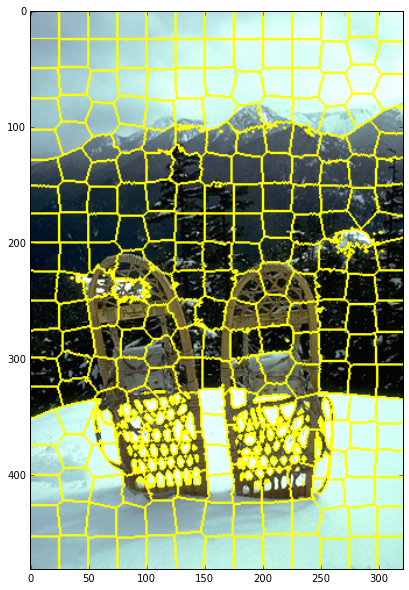

In [42]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
ax.imshow(marked)

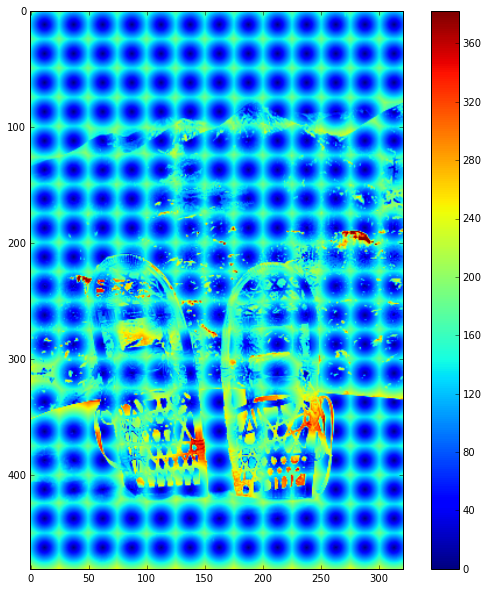

In [43]:
fig2, ax2 = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
heatmap = ax2.imshow(distance_start, vmin=min_dist, vmax=max_dist)
fig2.colorbar(heatmap);

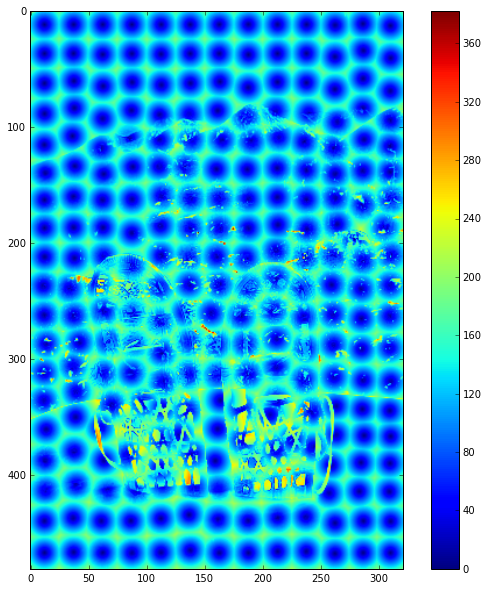

In [44]:
fig3, ax3 = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
heatmap2 = ax3.imshow(distance_end, vmin=min_dist, vmax=max_dist)
fig3.colorbar(heatmap2);

In [157]:
# print nearest_centers
# io.imsave('test_segments.tif', nearest_centers)
GT_segments = io.imread('Images/Q3/BSDS/2018_s1.tif')
# print GT_segments
# print nearest_centers
print UnderSegmentation(nearest_centers, GT_segments)

0.181922396876


In [70]:
# print bounds
# io.imsave('test_bounds.bmp', bounds)
GT_edges = io.imread('Images/Q3/BSDS/2018_e1.bmp')
GT_edges = GT_edges/255
# print bounds
print RecallThickened(bounds, GT_edges)

2.010995484


In [55]:
def RecallThickened(img, GT):
#     img = io.imread(edge_path, as_grey=True)
#     GT = io.imread(GT_path, as_grey=True).astype(int)

    #thickening GT
    GT_thickened = np.lib.pad(GT, ((3, 3)), 'constant').astype(int)
    for i in xrange(len(GT)):
        for j in xrange(len(GT[i])):
            if GT[i][j] == 1:
                for k in xrange(0,4):
                    GT_thickened[i+3-k][j+3]=1
                    GT_thickened[i+3-k][j+3-k]=1
                    GT_thickened[i+3-k][j+3+k]=1
                    GT_thickened[i+3+k][j+3]=1
                    GT_thickened[i+3+k][j+3-k]=1
                    GT_thickened[i+3+k][j+3+k]=1
                    GT_thickened[i+3][j+3+k]=1
                    GT_thickened[i+3][j+3-k]=1

    totalGT = 0
    totalImg = 0
    score = 0

    for i in range(len(GT)):
        for j in range(len(GT[i])):
            if GT[i][j] == 1:
                totalGT += 1
            if img[i][j] == 1:
                totalImg +=1
            if GT_thickened[i+3][j+3] == 1 and img[i][j] == 1:
                score += 1

    if totalImg == 0: totalImg = 1
    return float(score)/totalGT

In [9]:
GT = io.imread('Images/Q3/BSDS/15062_s5.tif').astype(int)
print np.unique(GT)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


In [155]:
def UnderSegmentation(img, GT):
#     img = io.imread(seg_path, as_grey=True)
#     GT = io.imread(GT_path, as_grey=True).astype(int)
    
    N = GT.shape[0] * GT.shape[1]
    
    intersection = segmentation.join_segmentations(img, GT)
    intersection_u = np.unique(intersection)
    intersection_map = {}
    for intersect in intersection_u:
        intersect_coors = np.where(intersection == intersect)
        intersection_map[intersect] = len(intersect_coors[0])
        
    img_u = np.unique(img)
    
    score = 0
    for segment in img_u:
        im_coors = np.where(img == segment)
        P = len(im_coors[0])
        check = {}
        for i in xrange(len(im_coors[0])):
            found = intersection[im_coors[0][i], im_coors[1][i]]
            try:
                check[found]
            except KeyError:
                check[found] = True
                subscore = P - intersection_map[found]
                score += min(intersection_map[found], subscore)
    return float(score) / N

In [156]:
s1 = np.array([[0, 0, 1, 1],
                [0, 2, 1, 1],
                [2, 2, 2, 1]])
s2 = np.array([[0, 1, 1, 0],
               [0, 1, 1, 0],
               [0, 1, 1, 1]])

UnderSegmentation(s1, s2)

0.6666666666666666